In [2]:
import time 
from math import sqrt
# from numpy import concatenate, max, min
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
#data in the right form
dataset = read_csv('Top5Data.csv', header=0, index_col=0)
values = dataset.values

#normalizing features, reframing data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# print(reframed.head())
reframed = series_to_supervised(scaled, 1, 1)  #(x, 73) for 72 values in the future, x is a hyperparameter
#dropping colums we do dont need
print(reframed.head())
reframed.drop(reframed.columns[[6,7,8,9]], axis = 1, inplace =True) #everthing after var1(t) must be dropped
print(reframed.head())
# arr = reframed["var1(t)"]
# print(arr)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  var2(t)  \
1   0.065207        0.0        0.0        0.0        0.0  0.056212      0.0   
2   0.056212        0.0        0.0        0.0        0.0  0.050118      0.0   
3   0.050118        0.0        0.0        0.0        0.0  0.044468      0.0   
4   0.044468        0.0        0.0        0.0        0.0  0.037090      0.0   
5   0.037090        0.0        0.0        0.0        0.0  0.033213      0.0   

   var3(t)  var4(t)  var5(t)  
1      0.0      0.0      0.0  
2      0.0      0.0      0.0  
3      0.0      0.0      0.0  
4      0.0      0.0      0.0  
5      0.0      0.0      0.0  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.065207        0.0        0.0        0.0        0.0  0.056212
2   0.056212        0.0        0.0        0.0        0.0  0.050118
3   0.050118        0.0        0.0        0.0        0.0  0.044468
4   0.044468        0.0        0.0        0.0        0.0  0.037090
5   

In [30]:
reframed.shape

(44260, 6)

In [31]:
#splitting into train/testing
values = reframed.values
n_train_hours = int(44260*.8)
train = values[:n_train_hours:, :]
test = values[n_train_hours:, :]
#input/output splitting
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X)

#3D input
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#desinging network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss ='mae', optimizer ='adam')

#fit network
history = model.fit(train_X, train_y, epochs=12, batch_size=64, validation_data=(test_X,test_y), verbose=2, shuffle=False)

[[0.06520715 0.         0.         0.         0.        ]
 [0.05621151 0.         0.         0.         0.        ]
 [0.05011839 0.         0.         0.         0.        ]
 ...
 [0.21724678 0.01010101 0.01182654 0.00833333 0.01084337]
 [0.19890099 0.01010101 0.01182654 0.00833333 0.01084337]
 [0.17242368 0.01010101 0.01182654 0.00833333 0.01084337]]
(35408, 1, 5) (35408,) (8852, 1, 5) (8852,)
Epoch 1/12
554/554 - 3s - loss: 0.0504 - val_loss: 0.0471 - 3s/epoch - 5ms/step
Epoch 2/12
554/554 - 1s - loss: 0.0242 - val_loss: 0.0213 - 1s/epoch - 2ms/step
Epoch 3/12
554/554 - 1s - loss: 0.0140 - val_loss: 0.0183 - 1s/epoch - 2ms/step
Epoch 4/12
554/554 - 1s - loss: 0.0118 - val_loss: 0.0181 - 1s/epoch - 2ms/step
Epoch 5/12
554/554 - 1s - loss: 0.0114 - val_loss: 0.0179 - 1s/epoch - 2ms/step
Epoch 6/12
554/554 - 1s - loss: 0.0114 - val_loss: 0.0177 - 1s/epoch - 2ms/step
Epoch 7/12
554/554 - 1s - loss: 0.0114 - val_loss: 0.0176 - 1s/epoch - 2ms/step
Epoch 8/12
554/554 - 1s - loss: 0.0115 - v

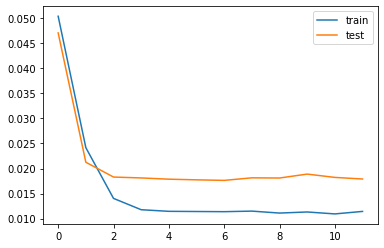

dict_keys(['loss', 'val_loss'])


In [32]:
#plot history
pyplot.plot(history.history['loss'], label= 'train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
print(history.history.keys())

In [33]:
#make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [43]:
def normalize(arr, maximum, minimum):
    return (arr - minimum) / (maximum - minimum)

#invert scale for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

#invert scale for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#calculateRMSE
maximum = max(inv_y)
minimum = min(inv_y)
# rnmse = sqrt(mean_squared_error(normalize(inv_y, maximum, minimum), normalize(inv_yhat, maximum, minimum)))
rnmse = mean_squared_error(normalize(inv_y, maximum, minimum), normalize(inv_yhat, maximum, minimum))
# rnmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RNMSE: %.3f' % rnmse)

Test RNMSE: 0.001


In [35]:
#calculating time
startTime = time.time()
print ('The script took {0} second !'.format(time.time() - startTime))

The script took 0.0 second !
